# Grab Repository data      

In [1]:
from dotenv import load_dotenv
from helper.general import split_by_date, generate_value_in_buckets, truncate_to_same_length, aggregate_by_date, get_repository_paths
from helper.significance import check_normality_of_buckets, calculate_cliffs_delta
import logging
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

load_dotenv(override=True)

True

In [2]:
REPO_PATHS = os.getenv('STORAGE_DIRECTORIES')
repository_directories = ast.literal_eval(REPO_PATHS) if REPO_PATHS else []
INTRO_DATE = os.getenv('INTRO_DATE')
BUCKET_SIZE = int(os.getenv('BUCKET_SIZE'))
START_DATE = os.getenv('START_DATE')
END_DATE = os.getenv('END_DATE')
RESULTS_DIRECTORY = os.getenv("RESULTS_DIRECTORY")
storage_path = f'{RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/commits_loc_added_per_{BUCKET_SIZE}_days.csv'

storage_dir = os.path.dirname(storage_path)
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir, exist_ok=True)

# Get only first-level subfolders in the repository directories
repositories = get_repository_paths(repository_directories)

print(repositories)

['/Users/annemariewittig/Master/repositoryanalysis/OSR/bootstrap', '/Users/annemariewittig/Master/repositoryanalysis/OSR/react-native', '/Users/annemariewittig/Master/repositoryanalysis/OSR/fastapi', '/Users/annemariewittig/Master/repositoryanalysis/OSR/vscode', '/Users/annemariewittig/Master/repositoryanalysis/OSR/gin', '/Users/annemariewittig/Master/repositoryanalysis/OSR/godot']


In [3]:
# if INTRO_DATE == "":
import json
mapping_file = f"{repository_directories[0]}/mapping.json"
# Check if the file exists
if not os.path.exists(mapping_file):
    print(f"File not found: {mapping_file}. ")
with open(mapping_file, 'r') as f:
    mapping = json.load(f)
# print(f"Using INTRO_DATE from mapping file: {INTRO_DATE}")


# Generate Commit Metrics per Repository

## Sum of lines of code added over time

Summed per bucket

In [4]:
commit_result = []
aggregation_column = 'loc_added'

for repository in repositories:
    if INTRO_DATE == "":
        person = repository.split('/')[-1]
        INTRO_DATE = mapping[person]['INTRO_DATE']
        START_DATE = mapping[person]['START_DATE']
        END_DATE = mapping[person]['END_DATE']
    commit_file = f"{repository}/commits.csv"
    # Check if the file exists
    if not os.path.exists(commit_file):
        print(f"File not found: {commit_file}. Skipping repository.")
        continue
    commit_df = pd.read_csv(commit_file)

    commit_df = truncate_to_same_length(commit_df, INTRO_DATE, 'date', 'defined', START_DATE, END_DATE)
    commit_df = aggregate_by_date(commit_df, 'date', 'loc_added', 'sum')
    
    pre_release, post_release = split_by_date(commit_df, INTRO_DATE, 'date')
    
    pre_release_buckets = generate_value_in_buckets(pre_release, 'date', aggregation_column, 'sum', BUCKET_SIZE, 'pre-')
    post_release_buckets = generate_value_in_buckets(post_release, 'date', aggregation_column, 'sum', BUCKET_SIZE, 'post-')

    release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)

    repo_name = repository.split('/')[-1]
    
    result_row = {'repository': repo_name}
    result_row.update(release_buckets.set_index('bucket')[aggregation_column].to_dict())  # Use 'count' instead of 'value'
    
    commit_result.append(result_row)
    print(repository)

# Create the DataFrame
commit_result_df = pd.DataFrame(commit_result)


/Users/annemariewittig/Master/repositoryanalysis/OSR/bootstrap
/Users/annemariewittig/Master/repositoryanalysis/OSR/react-native
/Users/annemariewittig/Master/repositoryanalysis/OSR/fastapi
/Users/annemariewittig/Master/repositoryanalysis/OSR/vscode
/Users/annemariewittig/Master/repositoryanalysis/OSR/gin
/Users/annemariewittig/Master/repositoryanalysis/OSR/godot


In [5]:
# Ensure the columns are in the correct order
def sort_buckets(df, prefix_one, prefix_two):
    order = ['repository']
    
    for prefix in [prefix_one, prefix_two]:
        counter = 0
        contained = True
        
        while contained:
            order.append(f'{prefix}{counter}')
            
            counter += 1
            if not f'{prefix}{counter}' in df:
                contained = False
        
    return order

columns_order = sort_buckets(commit_result_df, 'pre-', 'post-')
commit_result_df = commit_result_df[columns_order]

In [6]:
pre_release_buckets

,bucket,loc_added,start_date,end_date
0,pre-0,169272,2019-10-05 00:00:00+00:00,2020-01-03 00:00:00+00:00
1,pre-1,340394,2020-01-03 00:00:00+00:00,2020-04-02 00:00:00+00:00
2,pre-2,1704666,2020-04-02 00:00:00+00:00,2020-07-01 00:00:00+00:00
3,pre-3,794548,2020-07-01 00:00:00+00:00,2020-09-29 00:00:00+00:00
4,pre-4,658159,2020-09-29 00:00:00+00:00,2020-12-28 00:00:00+00:00
5,pre-5,376869,2020-12-28 00:00:00+00:00,2021-03-28 00:00:00+00:00
6,pre-6,477150,2021-03-28 00:00:00+00:00,2021-06-26 00:00:00+00:00
7,pre-7,743585,2021-06-26 00:00:00+00:00,2021-09-24 00:00:00+00:00
8,pre-8,7785923,2021-09-24 00:00:00+00:00,2021-12-23 00:00:00+00:00
9,pre-9,3928758,2021-12-23 00:00:00+00:00,2022-03-23 00:00:00+00:00


In [7]:
post_release_buckets

,bucket,loc_added,start_date,end_date
0,post-0,507201,2022-06-21 00:00:00+00:00,2022-09-19 00:00:00+00:00
1,post-1,593473,2022-09-19 00:00:00+00:00,2022-12-18 00:00:00+00:00
2,post-2,1048431,2022-12-18 00:00:00+00:00,2023-03-18 00:00:00+00:00
3,post-3,560042,2023-03-18 00:00:00+00:00,2023-06-16 00:00:00+00:00
4,post-4,396747,2023-06-16 00:00:00+00:00,2023-09-14 00:00:00+00:00
5,post-5,537052,2023-09-14 00:00:00+00:00,2023-12-13 00:00:00+00:00
6,post-6,505736,2023-12-13 00:00:00+00:00,2024-03-12 00:00:00+00:00
7,post-7,159041,2024-03-12 00:00:00+00:00,2024-06-10 00:00:00+00:00
8,post-8,376805,2024-06-10 00:00:00+00:00,2024-09-08 00:00:00+00:00
9,post-9,551067,2024-09-08 00:00:00+00:00,2024-12-07 00:00:00+00:00


In [8]:
storage_dir = os.path.dirname(storage_path)
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir, exist_ok=True)
    
print(storage_path)
commit_result_df.to_csv(storage_path)
# Show the entire width of the dataframe when displaying
with pd.option_context('display.max_columns', None):
    display(commit_result_df)

/Users/annemariewittig/Master/repo-analysis/results/OSR/metric_calculation_90/commits_loc_added_per_90_days.csv


,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,pre-9,pre-10,post-0,post-1,post-2,post-3,post-4,post-5,post-6,post-7,post-8,post-9,post-10
0,bootstrap,105575,19548,125960,12956,185443,136712,39361,163707,53170,18528,211646,39333,11743,214102,43794,10801,5240,15020,5600,29930,4073,57179
1,react-native,206846,497484,228984,553318,826792,654214,86088,59852,76219,43143,81321,60233,134457,59411,100765,126308,72688,174623,117048,310477,153479,231537
2,fastapi,5097,8594,12029,5490,18955,4921,6185,12224,10457,19467,4189,6705,5254,32753,76039,45477,14775,24744,28000,53571,31939,37409
3,vscode,189213,363378,183887,168995,191106,979642,304773,1678428,240456,250602,282591,219722,454395,301524,300877,264292,2409753,272691,816631,1267618,673128,59646
4,gin,2124,462,1267,232,212,477,1471,1644,923,624,1115,1227,296,2932,235,75,151,493,1524,652,973,61
5,godot,169272,340394,1704666,794548,658159,376869,477150,743585,7785923,3928758,1485506,507201,593473,1048431,560042,396747,537052,505736,159041,376805,551067,1320463


In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(commit_result_df)

     repository   pre-0   pre-1    pre-2   pre-3   pre-4   pre-5   pre-6  \
0     bootstrap  105575   19548   125960   12956  185443  136712   39361   
1  react-native  206846  497484   228984  553318  826792  654214   86088   
2       fastapi    5097    8594    12029    5490   18955    4921    6185   
3        vscode  189213  363378   183887  168995  191106  979642  304773   
4           gin    2124     462     1267     232     212     477    1471   
5         godot  169272  340394  1704666  794548  658159  376869  477150   

     pre-7    pre-8    pre-9   pre-10  post-0  post-1   post-2  post-3  \
0   163707    53170    18528   211646   39333   11743   214102   43794   
1    59852    76219    43143    81321   60233  134457    59411  100765   
2    12224    10457    19467     4189    6705    5254    32753   76039   
3  1678428   240456   250602   282591  219722  454395   301524  300877   
4     1644      923      624     1115    1227     296     2932     235   
5   743585  7785923  39

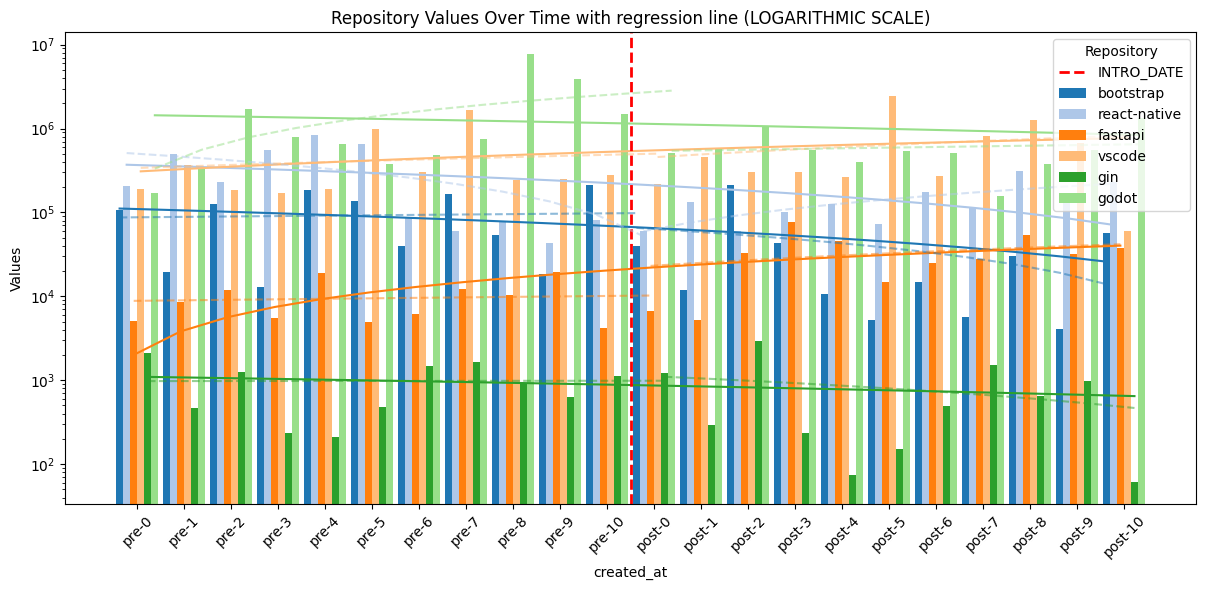

In [10]:
import numpy as np
from scipy.stats import linregress

# if len(commit_result_df['repository']) > 10:


tangent_data = []

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in commit_result_df.columns if col != 'repository']
# colors = ["#FF4500", "#FFA500", "#FF8C00", "#FFD700", "#FF6347", "#FF7F50", "#FFB347", "#FFCC99"]
# colors = ["#653F6C", "#BFD1E5", "#BAB700", "#FFCC99", "#439A86", "#808080", "#879970", "#896279"]
import matplotlib.pyplot as plt
colors = plt.cm.tab20.colors  # Use a colormap from matplotlib for distinct colors
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(commit_result_df['repository']):
    # Extract data for the current repository
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    m, b, _, _, _ = linregress(x, values.values)
    regression_line = m * x + b
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='-', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = commit_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))
    post_0 = 'post-0' if 'post-0' in post_columns else None
    
    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2

        # Vertical red line at midpoint
        plt.axvline(x=midpoint + (len(commit_result_df['repository']) - 1) * bar_width / 2,
                    color='red', linestyle='--', linewidth=2, label="INTRO_DATE")

# Plot bars and regression lines
for i, repo in enumerate(commit_result_df['repository']):
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)

    offset_x = x + i * bar_width
    plt.bar(offset_x, values.values, bar_width, label="_nolegend_", color=colors[i % len(colors)])

    if pre_columns and post_columns and largest_pre and post_0:
        # Indices for regression segments
        pre_range = np.arange(0, post_0_index + 1)
        post_range = np.arange(post_0_index, len(values))

        # Extract values
        pre_values = values.values[pre_range]
        post_values = values.values[post_range]

        # Regression before midpoint
        m_pre, b_pre, *_ = linregress(pre_range, pre_values)
        reg_line_pre = m_pre * pre_range + b_pre
        plt.plot(offset_x[pre_range], reg_line_pre, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Regression after midpoint
        m_post, b_post, *_ = linregress(post_range, post_values)
        reg_line_post = m_post * post_range + b_post
        plt.plot(offset_x[post_range], reg_line_post, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Collect regression parameters
        tangent_data.append({
            'repository': repo,
            'm_pre': m_pre,
            'b_pre': b_pre,
            'm_post': m_post,
            'b_post': b_post
        })




# Set x-axis ticks and labels
plt.xticks(x + (len(commit_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('created_at')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
plt.yscale('log')
plt.show()

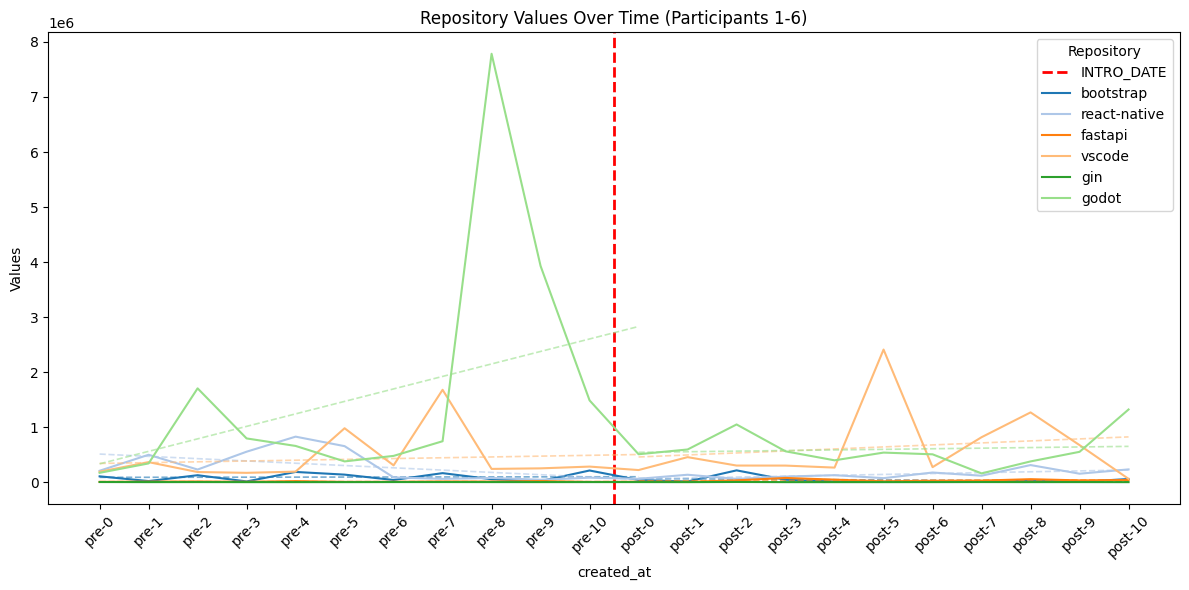

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

colors = plt.cm.tab20.colors
repos = commit_result_df['repository'].tolist()
date_columns = [col for col in commit_result_df.columns if col != 'repository']
x = np.arange(len(date_columns))

pre_columns = [col for col in date_columns if col.startswith('pre-')]
post_columns = [col for col in date_columns if col.startswith('post-')]

# Split into groups of 5
group_size = 6
for group_start in range(0, len(repos), group_size):
    group_repos = repos[group_start:group_start + group_size]
    plt.figure(figsize=(12, 6))
    tangent_data = []

    # Vertical line at introduction date midpoint
    if pre_columns and post_columns:
        largest_pre = max(pre_columns, key=lambda c: int(c.split('-')[1]))
        post_0 = 'post-0' if 'post-0' in post_columns else None
        if largest_pre and post_0:
            pre_index = date_columns.index(largest_pre)
            post_0_index = date_columns.index(post_0)
            midpoint = (pre_index + post_0_index) / 2
            plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=2, label="INTRO_DATE")

    for i, repo in enumerate(group_repos):
        values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
        color = colors[i % len(colors)]
        plt.plot(x, values.values, label=repo, color=color, linewidth=1.5)

        if pre_columns and post_columns and largest_pre and post_0:
            pre_range = np.arange(0, post_0_index + 1)
            post_range = np.arange(post_0_index, len(values))
            pre_values = values.values[pre_range]
            post_values = values.values[post_range]
            m_pre, b_pre, *_ = linregress(pre_range, pre_values)
            m_post, b_post, *_ = linregress(post_range, post_values)
            reg_line_pre = m_pre * pre_range + b_pre
            reg_line_post = m_post * post_range + b_post
            plt.plot(pre_range, reg_line_pre, linestyle='--', linewidth=1.2, color=color, alpha=0.6, label="_nolegend_")
            plt.plot(post_range, reg_line_post, linestyle='--', linewidth=1.2, color=color, alpha=0.6, label="_nolegend_")
            tangent_data.append({
                'repository': repo,
                'm_pre': m_pre,
                'b_pre': b_pre,
                'm_post': m_post,
                'b_post': b_post
            })

    plt.xticks(x, date_columns, rotation=45)
    plt.title(f'Repository Values Over Time (Participants {group_start+1}-{min(group_start+group_size, len(repos))})')
    plt.xlabel('created_at')
    plt.ylabel('Values')
    # plt.yscale('log')
    plt.legend(title='Repository')
    plt.tight_layout()
    plt.show()


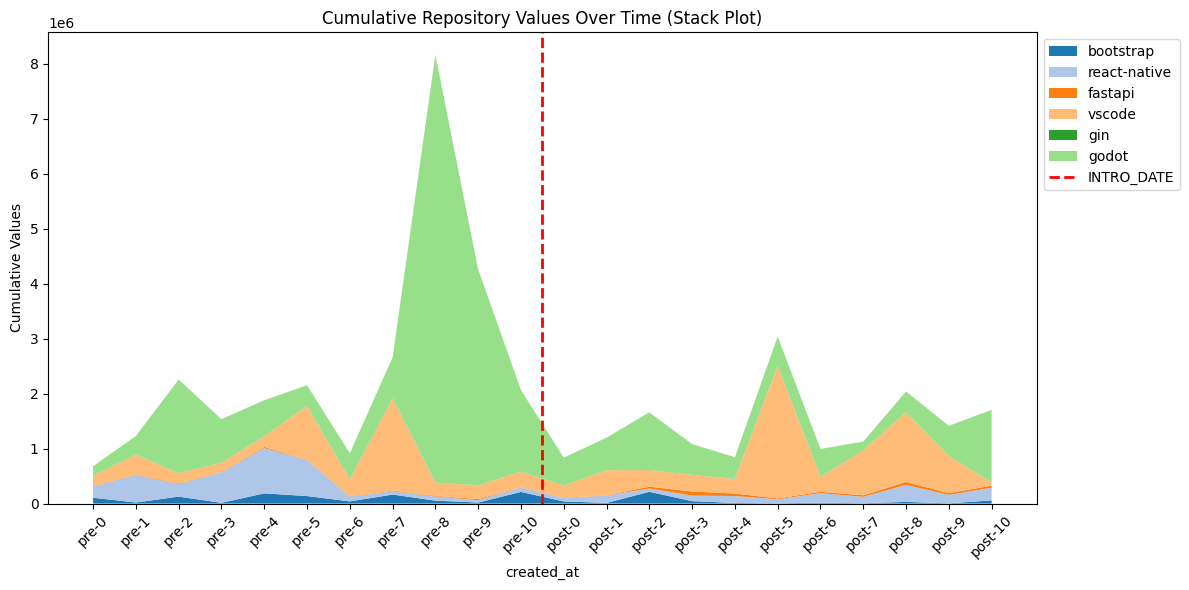

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data
date_columns = [col for col in commit_result_df.columns if col != 'repository']
x = np.arange(len(date_columns))  # x-axis positions
repos = commit_result_df['repository'].tolist()

# Matrix of values: shape (num_repos, num_dates)
y_values = np.vstack([
    commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0).values
    for repo in repos
])

# Plot stackplot
plt.figure(figsize=(12, 6))
colors = plt.cm.tab20.colors

plt.stackplot(x, y_values, labels=repos, colors=[colors[i % len(colors)] for i in range(len(repos))])
plt.xticks(x, date_columns, rotation=45)

# Optional vertical line at INTRO_DATE
pre_columns = [col for col in date_columns if col.startswith('pre-')]
post_columns = [col for col in date_columns if col.startswith('post-')]
if pre_columns and post_columns and 'post-0' in post_columns:
    largest_pre = max(pre_columns, key=lambda c: int(c.split('-')[1]))
    post_0 = 'post-0'
    pre_index = date_columns.index(largest_pre)
    post_index = date_columns.index(post_0)
    midpoint = (pre_index + post_index) / 2
    plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=2, label="INTRO_DATE")

# Labels and formatting
plt.title('Cumulative Repository Values Over Time (Stack Plot)')
plt.xlabel('created_at')
plt.ylabel('Cumulative Values')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
# plt.yscale('log')  # Optional: remove if stacking leads to log distortions
plt.show()


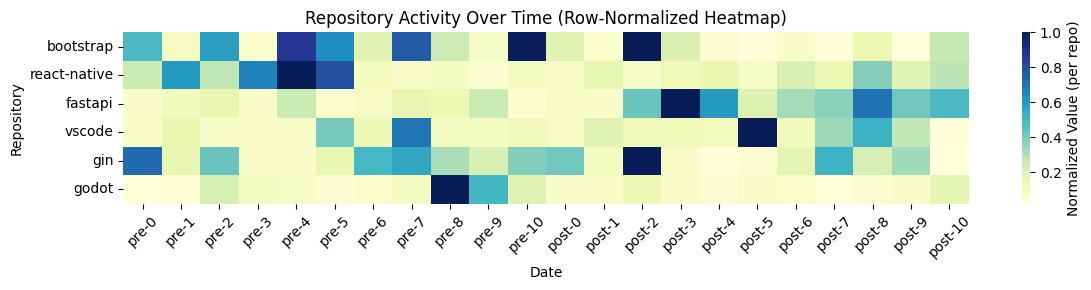

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
data_matrix = commit_result_df.set_index('repository').astype(float).fillna(0)

# Row-normalize: divide each row by its max (avoid division by 0)
normalized_data = data_matrix.div(data_matrix.max(axis=1).replace(0, np.nan), axis=0)

plt.figure(figsize=(12, 0.5 * len(normalized_data)))
sns.heatmap(normalized_data, cmap="YlGnBu", cbar_kws={'label': 'Normalized Value (per repo)'})
plt.title('Repository Activity Over Time (Row-Normalized Heatmap)')
plt.xlabel('Date')
plt.ylabel('Repository')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


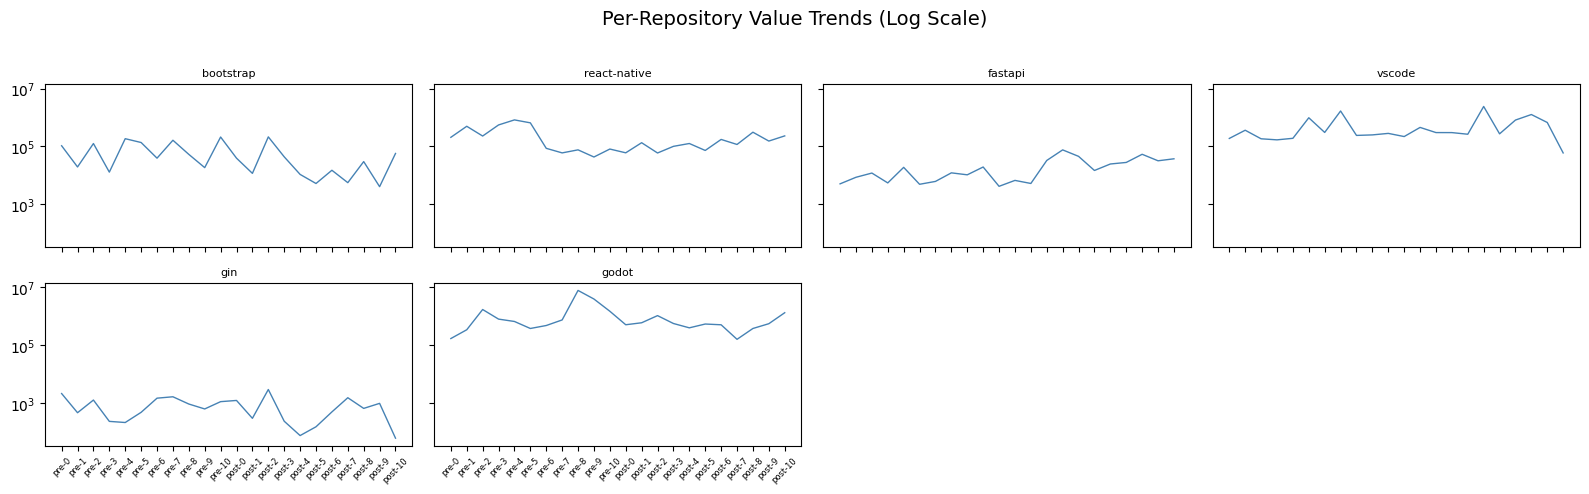

In [14]:
import matplotlib.pyplot as plt

repos = commit_result_df['repository']
date_columns = [col for col in commit_result_df.columns if col != 'repository']
x = np.arange(len(date_columns))

n = len(repos)
cols = 4
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 2.5 * rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, repo in enumerate(repos):
    ax = axes[i]
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    ax.plot(x, values.values, color='steelblue', linewidth=1)
    ax.set_title(repo, fontsize=8)
    ax.set_xticks(x)
    ax.set_xticklabels(date_columns, rotation=45, fontsize=6)
    ax.set_yscale('log')

# Remove unused subplots
for i in range(n, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle('Per-Repository Value Trends (Log Scale)', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


bootstrap


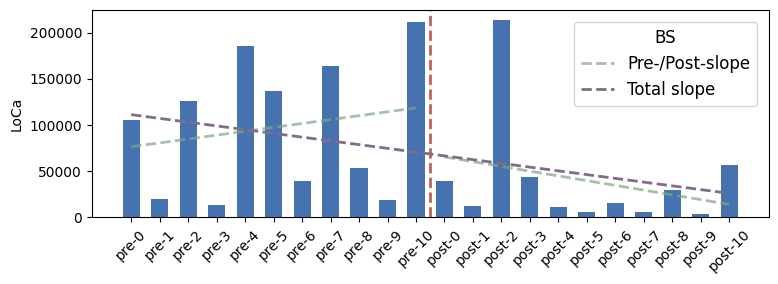

react-native


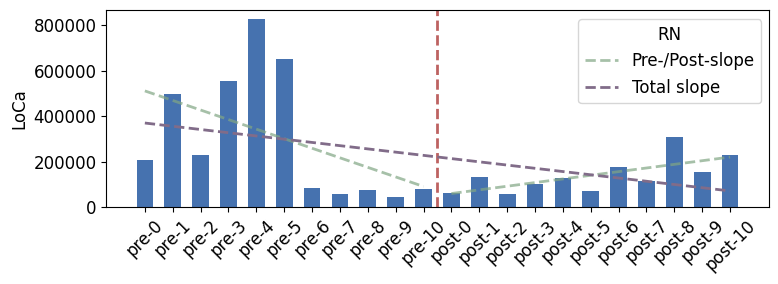

fastapi


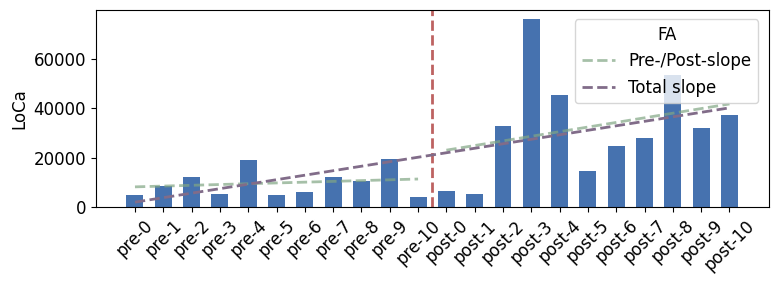

vscode


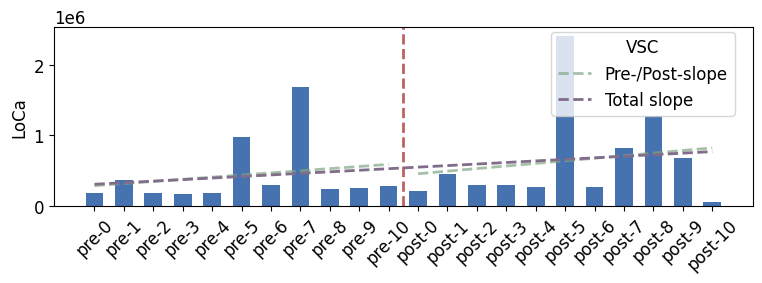

gin


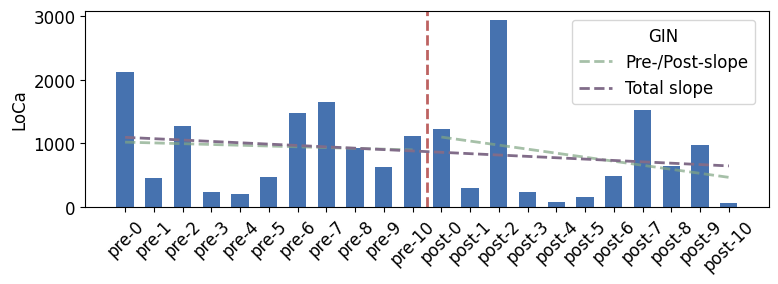

godot


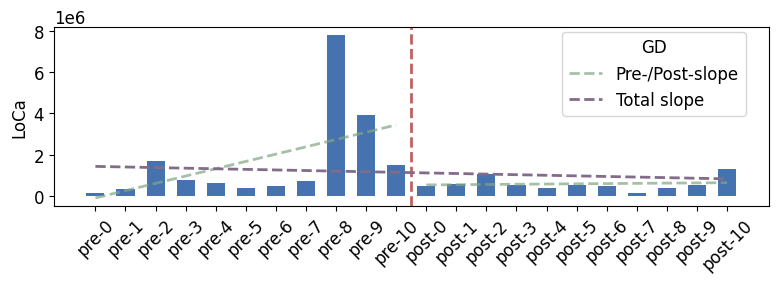

In [15]:
def compute_slope(row, cols):
    y = row[cols].values.astype(float)
    x = np.arange(len(y))
    
    # Remove NaN values from both x and y
    valid_indices = ~np.isnan(y)
    x = x[valid_indices]
    y = y[valid_indices]
    
    # Check if there are enough points to calculate a slope
    if len(y) < 2:
        return np.nan  # Not enough data points to calculate a slope
    
    return np.polyfit(x, y, 1)[0]

for i, repo in enumerate(commit_result_df['repository']):
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    print(repo)
    plt.figure(figsize=(8, 3))
    offset_x = x + i * bar_width
    plt.bar(offset_x, values.values, 0.6, color='#4672AF')
    plt.rcParams.update({'font.size': 12})
    # Find pre and post columns
    pre_columns = [col for col in date_columns if col.startswith('pre-')]
    post_columns = [col for col in date_columns if col.startswith('post-')]
    largest_pre = max(pre_columns, key=lambda c: int(c.split('-')[1])) if pre_columns else None
    post_0 = 'post-0' if 'post-0' in post_columns else None

    if largest_pre and post_0:
        pre_index = date_columns.index(largest_pre)
        post_0_index = date_columns.index(post_0)
        midpoint = (pre_index + post_0_index) / 2
        plt.axvline(x=midpoint + i * bar_width, color='#BD6261', linestyle='--', linewidth=2)

        # Pre and post ranges
        pre_range = np.arange(0, post_0_index + 1)
        post_range = np.arange(post_0_index, len(values))

        # Pre and post regression using compute_slope
        # Pre and post ranges
        pre_cols = date_columns[0:post_0_index]
        post_cols = date_columns[post_0_index:]

        # For regression lines, use np.polyfit to get both slope and intercept
        if len(pre_cols) > 1:
            m_pre = compute_slope(values, pre_cols)
            b_pre = np.polyfit(np.arange(len(pre_cols)), values[pre_cols].values, 1)[1]
            reg_line_pre = m_pre * np.arange(len(pre_cols)) + b_pre
            plt.plot(offset_x[:len(pre_cols)], reg_line_pre, linestyle='--', linewidth=2, color='#81A684', alpha=0.7, label="Pre-/Post-slope")
        if len(post_cols) > 1:
            m_post = compute_slope(values, post_cols)
            b_post = np.polyfit(np.arange(len(post_cols)), values[post_cols].values, 1)[1]
            reg_line_post = m_post * np.arange(len(post_cols)) + b_post
            plt.plot(offset_x[post_0_index:post_0_index+len(post_cols)], reg_line_post, linestyle='--', linewidth=2, color='#81A684', alpha=0.7, label="")

    # Overall regression (dashed, black) using compute_slope
    m_total = compute_slope(values, date_columns)
    if not np.isnan(m_total):
        b_total = np.polyfit(np.arange(len(date_columns)), values[date_columns].values, 1)[1]
        regression_line = m_total * np.arange(len(date_columns)) + b_total
        plt.plot(offset_x, regression_line, color='#816C89', linestyle='--', linewidth=2, label="Total slope")

    plt.xticks(offset_x, date_columns, rotation=45)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('LoCa')
    plt.legend(title=mapping[repo]['SYNONYM'], loc='center left', bbox_to_anchor=(0.7, 0.74))
    plt.tight_layout()
    
    if mapping[repo]['SYNONYM'] in ['P2', 'P4', 'P5']:
        save_dir = os.path.dirname(storage_path)
        pdf_path = f"{save_dir}/{mapping[repo]['SYNONYM']}.pdf"
        plt.savefig(pdf_path)
    
    # plt.yscale('log')
    plt.show()

# Significancetest 

In [16]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Replace NaN values with 0 in the commit_result_df
commit_result_df = commit_result_df.fillna(0)

# Columns for pre and after buckets
pre_columns = [col for col in commit_result_df.columns if col.startswith("pre-")]
after_columns = [col for col in commit_result_df.columns if col.startswith("post-")]

normality_results = check_normality_of_buckets(commit_result_df, pre_columns, after_columns)

# Display the results
print(normality_results)

     repository  pre_p_value  after_p_value  pre_normal  after_normal
0     bootstrap     0.239382       0.000028        True         False
1  react-native     0.031932       0.174984       False          True
2       fastapi     0.060879       0.678541        True          True
3        vscode     0.000040       0.001916       False         False
4           gin     0.553555       0.013681        True         False
5         godot     0.000180       0.027923       False         False


In [17]:
from helper.significance import calculate_cliffs_delta_with_confidence
significance_results_df = calculate_cliffs_delta_with_confidence(commit_result_df, pre_columns, after_columns)

# Display the results
print(significance_results_df)

     repository      test_used  effect_size  ci_lower  ci_upper
0     bootstrap  Cliff's Delta    -0.553719 -0.900826 -0.123554
1  react-native  Cliff's Delta    -0.190083 -0.685950  0.388430
2       fastapi  Cliff's Delta     0.735537  0.354959  1.000000
3        vscode  Cliff's Delta     0.289256 -0.206612  0.735537
4           gin  Cliff's Delta    -0.239669 -0.669421  0.239669
5         godot  Cliff's Delta    -0.289256 -0.735537  0.223140


In [18]:
merged = commit_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

with pd.option_context('display.max_columns', None):
    display(merged)
# merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,pre-9,pre-10,post-0,post-1,post-2,post-3,post-4,post-5,post-6,post-7,post-8,post-9,post-10,test_used,effect_size,ci_lower,ci_upper
0,bootstrap,105575,19548,125960,12956,185443,136712,39361,163707,53170,18528,211646,39333,11743,214102,43794,10801,5240,15020,5600,29930,4073,57179,Cliff's Delta,-0.553719,-0.900826,-0.123554
1,react-native,206846,497484,228984,553318,826792,654214,86088,59852,76219,43143,81321,60233,134457,59411,100765,126308,72688,174623,117048,310477,153479,231537,Cliff's Delta,-0.190083,-0.685950,0.388430
2,fastapi,5097,8594,12029,5490,18955,4921,6185,12224,10457,19467,4189,6705,5254,32753,76039,45477,14775,24744,28000,53571,31939,37409,Cliff's Delta,0.735537,0.354959,1.000000
3,vscode,189213,363378,183887,168995,191106,979642,304773,1678428,240456,250602,282591,219722,454395,301524,300877,264292,2409753,272691,816631,1267618,673128,59646,Cliff's Delta,0.289256,-0.206612,0.735537
4,gin,2124,462,1267,232,212,477,1471,1644,923,624,1115,1227,296,2932,235,75,151,493,1524,652,973,61,Cliff's Delta,-0.239669,-0.669421,0.239669
5,godot,169272,340394,1704666,794548,658159,376869,477150,743585,7785923,3928758,1485506,507201,593473,1048431,560042,396747,537052,505736,159041,376805,551067,1320463,Cliff's Delta,-0.289256,-0.735537,0.223140


# Interpretation
- bootstra